# Tutorial for Sentinel-1 Flood Analysis: Transfer Learning and Embedding Applications


## GRAD-E1394 Deep Learning - Assignment 3

Authors:


*   Aditi Joshi
*   Elena Murray
*   Leticia Figueiredo Collado
*   Sattiki Ganguly
*   Xiaohan Wu

This tutorial demonstrates transfer learning for flood detection by adapting a ResNet-34 encoder pretrained on ImageNet to Sentinel-1 SAR imagery, using a two-stage training approach (frozen encoder then full fine-tuning) to achieve 94.8% accuracy with only 150 training images. The transfer learning approach produces reusable embeddings that enable multiple downstream applications including flood classification, similarity search, and clustering without retraining the model.

### Table of Contents 

* Memo
* Overview
* Important Concepts 
* Software Requirements 
* Data Description, Data Loading and Preprocessing 
* Phase 1 - Two step transfer learning for flood segmentation 
* Phase 2 - Using Learned Embeddings for Downstream Analysis
* Downstream Tasks
* Summary 
* References
* AI statement 



### Memo

Flood monitoring remains a persistent challenge for governments and disaster-response agencies worldwide. Floods typically occur during extreme weather conditions, rendering optical satellite imagery unusable due to cloud cover. Large geographic areas must be monitored simultaneously, requiring rapid and scalable analysis that exceeds manual capacity. Additionally, high-quality labeled flood data is extremely limited, as flood events are unpredictable, short-lived, and difficult to annotate in real time. Traditional threshold-based approaches require manual calibration and fail under varying environmental conditions, causing critical delays in evacuations, damage assessments, and aid allocation. Empirical work, such as the Sen1Floods11 dataset (Bonafilia et al., 2020), demonstrates that deep-learning models trained from scratch perform inconsistently across regions due to data scarcity. 

This tutorial addresses these challenges by demonstrating how pretrained models can be adapted for flood detection using Sentinel-1 SAR imagery, with a focus on data points from India, US, and Paraguay. We focus on transfer learning, a method that reuses pretrained neural networks (such as ResNet34) by adapting them to new tasks with minimal data. Transfer learning works by leveraging feature representations learned from millions of images—such as edges, textures, and patterns—and fine-tuning these features for the specific task of flood detection. Rather than training all network layers from scratch, we initially freeze the pretrained layers and train only the final classification layer, then gradually unfreeze earlier layers to adapt the model to SAR imagery characteristics. 

Transfer learning offers several practical advantages: it dramatically reduces the need for extensive labeled datasets, making it highly data-efficient for resource-constrained applications. The freeze–unfreeze training strategy enables progressive model adaptation while illustrating how network capacity is gradually expanded. Compared to training from scratch, this approach typically achieves higher accuracy with available data, making it accessible for students, researchers, and practitioners working on real-world monitoring systems without requiring expensive computational infrastructure or extensive labeled datasets. 




## Overview

This tutorial demonstrates how to apply deep learning techniques to flood detection using freely available Sentinel-1 radar satellite imagery. Through a hands-on, reproducible workflow, we build and deploy a practical flood-mapping system using transfer learning and embedding-based analysis.

The tutorial is divided into two main phases. In Phase 1, we built a flood segmentation model using a two-stage transfer learning approach. Transfer learning is the core technique that makes this tutorial efficient and accessible: instead of training a deep neural network from scratch (which would require massive datasets and computational resources), we started with a U-Net architecture containing a ResNet-34 encoder that has already been pretrained on ImageNet's millions of natural images. We then adapted this pretrained model to the specialized task of flood detection in SAR imagery. The training proceeded in two stages—first freezing the encoder to train only the decoder, then fine-tuning the entire network with a lower learning rate. This transfer learning strategy allowed us to achieve robust performance on multi-country flood events from the Sen1Floods11 dataset using only 150 training images.

In Phase 2, we leveraged the learned embeddings from our trained model for downstream analysis tasks. We extracted reusable 512-dimensional feature representations from the encoder and applied them to four practical applications: chip-level flood classification using logistic regression, image similarity searches to find historical flood events resembling new disasters, unsupervised clustering to discover distinct flood patterns, and cross-regional comparison using cosine similarity metrics. Importantly, these downstream tasks required no additional model training, demonstrating the versatility and efficiency of the transfer learning approach.

This tutorial requires no specialized hardware and runs entirely in Google Colab with GPU support. By the end of the tutorial, we understood how to leverage transfer learning to build efficient flood-mapping systems and extract meaningful insights from satellite imagery—skills directly applicable to real-world challenges in emergency response, disaster insurance, infrastructure planning, and climate adaptation.




### Background

Lets start by understanding important concepts for this tutorial- 


#### Transfer Learning:
In transfer learning, a model developed for one task can be reused or adapted for another target task​. The initial model has learned useful patterns and holds knowledge that can be fine-tuned or repurposed to a different problem​. Transfer learning is helpful in case of limited labeled data, or when re-training is too expensive​. 


![my image](image1.png)



Transfer Learning has various types based on tasks and if the data at source and target is labled or not. 
#### Inductive Transfer Learning- 
Learning occurs when the source and target tasks are different but related and both datasets are labaled. Our tutorial uses this approach, transferring from ImageNet classification to SAR flood segmentation with labeled data in both domains.
#### Transductive Transfer Learning-
Learning applies when the source and target tasks are the same, but the domains differ. The model adapts to domain shift while maintaining the same prediction objective.
#### Unsupervised Transfer Learning-
It involves transferring knowledge when there are no labeled data in either the source or target domain. This is the least common scenario and relies on learning general representations without supervision.

As stated above we are conducting Inductive tranfer learning in this tutorial. 


#### Convolutional Neural Networks (CNNs)

Convolutional Neural Networks are deep learning models designed specifically for processing images. CNNs apply learnable filters that slide across an image to detect local patterns. These filters automatically learn features at different levels of abstraction—early layers detect simple patterns like edges and corners, while deeper layers combine these into complex representations like textures and structures. This hierarchical feature extraction makes CNNs powerful for satellite imagery analysis because they can automatically learn to recognize flood patterns, water bodies, and land features without manual programming.

#### Semantic Segmentation

Semantic segmentation is a computer vision task that classifies every single pixel in an image into a predefined category. Unlike image classification (which labels entire images) or object detection (which draws bounding boxes), semantic segmentation produces a detailed pixel-level map. 

#### Feature Embeddings

Feature embeddings are compact numerical representations that capture meaningful patterns from images in a fixed-size vector. In our tutorial, we extract 512-dimensional embeddings by taking the deepest feature maps from the trained encoder and applying global average pooling to compress spatial information into a single vector per image. These embeddings encode learned characteristics like water texture, flood extent, and landscape features. The key advantage is that once extracted, these embeddings can be reused for multiple downstream tasks—classification, similarity search, clustering—without retraining the full segmentation model.



#### Software Requirements
This tutorial can be run entirely in Google Colab and we strongly recommend using a GPU runtime due to the processing requirements of satellite imagery and deep learning models.

All required libraries are already available in Colab:

- torch 
- deep learning franework for model training
torchvision 
- pretrained CNN backbones for transfer learning
numpy, pandas 
- data handling
- rasterio 
- reading GeoTIFF satellite images
matplotlib 
- plotting
sklearn 
- metrics and processing utilities
gsutil 
- tool to download data directly from Google Cloud Storage

We start by running the following code to install required libraries, connect to a gpu if available, and set a random seed for reproducibility.

In [4]:
# Install all required packages
!pip install -q segmentation-models-pytorch
!pip install -q rasterio

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Standard imports
import torch
import torch.nn as nn
import numpy as np
import rasterio
import segmentation_models_pytorch as smp
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import random

# Check environment
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"✅ Environment ready!")
print(f"   Device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")

# Set random seeds
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

✅ Environment ready!
   Device: cuda
   GPU: Tesla T4


### Data Description
In this tutorial, we use a small curated subset of the Sen1Floods11 dataset which is a public, georeferenced benchmark for training flood-mapping models from satellite data. Sentinel-1 is a Synthetic Aperture Radar (SAR) mission that provides microwave imagery independent of daylight or weather conditions—making it particularly valuable for flood monitoring. The dataset contains flood events across multiple countries and includes:

Hand-labeled flood masks, where each pixel is annotated as:
- 1 = water (flooded)
- 0 = non-water
- -1 = no data / invalid

Each data example is called a chip, representing a 512 x 512
 10m pixels from a single flood event. Every chip has a corresponding JSON metadata file that includes asset links to imagery and masks.


Each Sentinel-1 image contains two polarization channels:

VV Polarization (Vertical Transmit, Vertical Receive)

Measures backscatter where the transmitted and received microwaves are both vertically polarized.
Highly sensitive to surface roughness (soil, open water, built structures).
Open water appears very dark in VV because smooth water surfaces scatter the radar signal away from the sensor.
Excellent for detecting open-water flood extents.
VH Polarization (Vertical Transmit, Horizontal Receive)

Measures microwaves transmitted vertically but received horizontally.
Sensitive to volume scattering, especially from vegetation, crop fields, and forest canopies.
Flooded vegetation produces stronger VH returns due to “double-bounce” interactions between water and plant stems.
Useful for detecting flooding beneath vegetation, which is often invisible in VV alone.

The full dataset is provided by Cloud to Street and accessible via: gs://sen1floods11/v1.1/.

Source: Bonafilia et al. Sen1Floods11: A Georeferenced Dataset to Train and Test Deep Learning Flood Algorithms for Sentinel-1, CVPRW 2020. Available at: http://openaccess.thecvf.com/content_CVPRW_2020/html/w11/Bonafilia_Sen1Floods11_A_Georeferenced_Dataset_to_Train_and_Test_Deep_Learning_CVPRW_2020_paper.html.

## Data Loading and Pre-processing

### Data Loading

The dataset is available for access through Google Cloud Storage bucket at: gs://senfloods11/

First, we access the data and conduct some exploratory data analysis by viewing the number of chips per country. We then take a subset of the dataset for ease of analysis and computation in this tutorial by selecting a total of 150 chips from the USA, India and Paraguay (the three countries that had the largest number of chips in the full dataset). 

In [5]:
!gsutil ls gs://sen1floods11/v1.1/catalog/sen1floods11_hand_labeled_label/ > chip_list.txt

with open("chip_list.txt") as f:
    chip_dirs = [line.strip() for line in f]

chip_dirs = [d for d in chip_dirs if d.endswith("_label/")]

def parse_chip(d):
    name = d.rstrip("/").split("/")[-1].replace("_label", "")
    country = name.split("_")[0]
    return country, name

chip_info = [parse_chip(d) for d in chip_dirs]

In [6]:
# Count chips per country
from collections import Counter
country_counts = Counter([country for country, _ in chip_info])

print("Chips per country:")
for country, count in sorted(country_counts.items(), key=lambda x: -x[1])[:10]:
    print(f"  {country}: {count}")

Chips per country:
  USA: 69
  India: 68
  Paraguay: 67
  Ghana: 53
  Sri-Lanka: 42
  Mekong: 30
  Spain: 30
  Pakistan: 28
  Somalia: 26
  Nigeria: 18


In [7]:
target_per_country = 50
selected_countries = ["India", "USA", "Paraguay"]

selected_chips = []
for country in selected_countries:
    country_chips = [name for c, name in chip_info if c == country]
    # Take up to target_per_country from each
    selected_chips.extend(country_chips[:target_per_country])

print(f"\nSelected {len(selected_chips)} chips from {len(selected_countries)} countries")
print(f"Target: ~150 chips for balanced dataset")


Selected 150 chips from 3 countries
Target: ~150 chips for balanced dataset


### Data Pre-Processing

We need to define URL prefixes in order to access files directly from Google Cloud Storage using rasterio, which avoids us needing to download the full data set locally (which is 14GB in total). We also need to normalise and clean the Sentinel-1 SAR images as part of the pre-processing. 

To avoid overfitting, we apply random data augmentations via rotations, flips, brightness scaling, guassian noise, and cropping and resizing.

In [8]:
import torch
import numpy as np
import rasterio
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms.functional as F
import torchvision.transforms as T
import random

# GCS streaming prefixes
HTTP_PREFIX = "https://storage.googleapis.com/sen1floods11/v1.1"
S1_PREFIX    = f"/vsicurl/{HTTP_PREFIX}/data/flood_events/HandLabeled/S1Hand"
LABEL_PREFIX = f"/vsicurl/{HTTP_PREFIX}/data/flood_events/HandLabeled/LabelHand"

# ========================================
# ENHANCED AUGMENTATION
# ========================================

class Sentinel1FloodDataset(Dataset):
    def __init__(self, id_list, augment=False):
        self.ids = id_list
        self.augment = augment

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        cid = self.ids[idx]
        s1_path = f"{S1_PREFIX}/{cid}_S1Hand.tif"
        label_path = f"{LABEL_PREFIX}/{cid}_LabelHand.tif"

        # Load data
        with rasterio.open(s1_path) as src:
            s1_img = src.read().astype("float32")

        # SAR normalization
        s1_img = np.nan_to_num(s1_img)
        s1_img = np.clip(s1_img, -50, 50)
        s1_img = np.log1p(s1_img - s1_img.min())
        s1_img = (s1_img - s1_img.mean()) / (s1_img.std() + 1e-6)

        with rasterio.open(label_path) as src:
            mask_raw = src.read(1).astype("int16")

        valid_mask = (mask_raw != -1)
        label = (mask_raw == 1).astype("float32")

        # Enhanced augmentation
        if self.augment:
            # Existing augmentations
            if random.random() > 0.5:
                s1_img = np.flip(s1_img, axis=2).copy()
                label = np.flip(label, axis=1).copy()
                valid_mask = np.flip(valid_mask, axis=1).copy()
            
            if random.random() > 0.5:
                s1_img = np.flip(s1_img, axis=1).copy()
                label = np.flip(label, axis=0).copy()
                valid_mask = np.flip(valid_mask, axis=0).copy()
            
            k = random.randint(0, 3)
            if k > 0:
                s1_img = np.rot90(s1_img, k, axes=(1, 2)).copy()
                label = np.rot90(label, k, axes=(0, 1)).copy()
                valid_mask = np.rot90(valid_mask, k, axes=(0, 1)).copy()
            
            # NEW: Random brightness adjustment (simulate different conditions)
            if random.random() > 0.5:
                brightness_factor = random.uniform(0.8, 1.2)
                s1_img = s1_img * brightness_factor
            
            # NEW: Add slight Gaussian noise (simulate sensor noise)
            if random.random() > 0.5:
                noise = np.random.normal(0, 0.05, s1_img.shape).astype('float32')
                s1_img = s1_img + noise
            
            # NEW: Random crop and resize (slight scale variation)
            if random.random() > 0.3:
                crop_size = random.randint(480, 512)
                if crop_size < 512:
                    # Crop
                    h_start = random.randint(0, 512 - crop_size)
                    w_start = random.randint(0, 512 - crop_size)
                    s1_img = s1_img[:, h_start:h_start+crop_size, w_start:w_start+crop_size]
                    label = label[h_start:h_start+crop_size, w_start:w_start+crop_size]
                    valid_mask = valid_mask[h_start:h_start+crop_size, w_start:w_start+crop_size]
                    
                    # Resize back to 512x512
                    import torch.nn.functional as F
                    s1_img = torch.tensor(s1_img).unsqueeze(0)
                    s1_img = F.interpolate(s1_img, size=(512, 512), mode='bilinear', align_corners=False)
                    s1_img = s1_img.squeeze(0).numpy()
                    
                    label = torch.tensor(label).unsqueeze(0).unsqueeze(0)
                    label = F.interpolate(label, size=(512, 512), mode='nearest')
                    label = label.squeeze(0).squeeze(0).numpy()
                    
                    valid_mask = torch.tensor(valid_mask.astype('float32')).unsqueeze(0).unsqueeze(0)
                    valid_mask = F.interpolate(valid_mask, size=(512, 512), mode='nearest')
                    valid_mask = valid_mask.squeeze(0).squeeze(0).numpy().astype(bool)

        x = torch.tensor(s1_img, dtype=torch.float32)
        y = torch.tensor(label, dtype=torch.float32)[None, ...]
        valid = torch.tensor(valid_mask, dtype=torch.bool)[None, ...]

        return x, y, valid

The below function takes the model tensors (SAR image, label mask, and validity mask) and converts them into normalized 0–255 grayscale PIL images for visualization. It rescales the VV and VH SAR channels into displayable grayscale ranges and converts the label and valid masks into binary images, making all four outputs easy to view or save.

In [9]:
def tensor_to_pil_pair(x, y, valid):
    vv = x[0].cpu().numpy()
    vh = x[1].cpu().numpy()
    label_arr = y[0].cpu().numpy()
    valid_arr = valid[0].cpu().numpy().astype(np.uint8)

    # Normalize to 0-255 range for visualization
    vv_norm = ((vv - vv.min()) / (vv.max() - vv.min() + 1e-8) * 255).astype(np.uint8)
    vh_norm = ((vh - vh.min()) / (vh.max() - vh.min() + 1e-8) * 255).astype(np.uint8)

    vv_pil = Image.fromarray(vv_norm)
    vh_pil = Image.fromarray(vh_norm)
    label_pil = Image.fromarray((label_arr * 255).astype(np.uint8))
    valid_pil = Image.fromarray((valid_arr * 255).astype(np.uint8))

    return vv_pil, vh_pil, label_pil, valid_pil

In [10]:
def preprocess_test(x, y, valid):
    return x, y, valid

## Phase 1: Two-Step Transfer Learning for Flood Segmentation

In this task, we will train an flood segmentation model to demonstrate a two-stage transfer learning approach.

### Split into training, test and validation data

To start with, we shuffle the dataset IDs with a fixed random seed, and split them into 70% training, 15% validation, and 15% test sets. 

Once we create the training, validation, and test datasets, we wrap them in PyTorch DataLoaders for batching and efficient loading. We also enable augmentation only for the training data, and check the available GPU memory before running the model. 

In [11]:
valid_ids = sorted(selected_chips)

np.random.seed(42)
np.random.shuffle(valid_ids)

n = len(valid_ids)
train_ids = valid_ids[:int(0.7*n)]
val_ids   = valid_ids[int(0.7*n):int(0.85*n)]
test_ids  = valid_ids[int(0.85*n):]

print(f"Train: {len(train_ids)}  Val: {len(val_ids)}  Test: {len(test_ids)}")

Train: 105  Val: 22  Test: 23


In [18]:
batch_size = 8

train_ds = Sentinel1FloodDataset(train_ids, augment=True)
val_ds   = Sentinel1FloodDataset(val_ids,   augment=False)
test_ds  = Sentinel1FloodDataset(test_ids,  augment=False)

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2)

if torch.cuda.is_available():
    print(f"GPU memory allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
    print(f"GPU memory reserved: {torch.cuda.memory_reserved() / 1e9:.2f} GB")

GPU memory allocated: 0.48 GB
GPU memory reserved: 4.66 GB


### Define the model architecture and the training, validation, evaluation and loss functions

We use a combined loss function that averages Binary Cross-Entropy with Logits (BCE) and Dice loss to train the flood segmentation model. BCE provides stable pixel-wise classification, while Dice loss directly measures the overlap between predicted and true flood regions, making it well-suited for imbalanced datasets where flooded pixels may be sparse. 

For the model architecture, we use a U-Net with a ResNet-34 encoder pretrained on ImageNet. This is the same model architecture that is used by Bonafilia et al. (2020) in their paper. The pretrained encoder provides strong feature extraction capabilities through transfer learning, which is especially valuable when training on limited flood-labelled SAR data. The network is configured to accept two-channel Sentinel-1 inputs (VV and VH) and produce a single-channel binary flood mask.

In [13]:
import segmentation_models_pytorch as smp
import torch
import torch.nn as nn

# Define loss functions
dice_loss = smp.losses.DiceLoss(mode='binary')
bce_loss = nn.BCEWithLogitsLoss()

class CombinedLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.dice = dice_loss
        self.bce = bce_loss
    
    def forward(self, logits, target):
        return 0.5 * self.dice(torch.sigmoid(logits), target) + 0.5 * self.bce(logits, target)

criterion = CombinedLoss()

# U-Net with ResNet34 encoder pre-trained on ImageNet
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",   # Transfer learning
    in_channels=2,                # VV + VH
    classes=1                     # Binary mask
).to(device)

The below functions compute two common evaluation metrics for binary flood segmentation: Intersection over Union (IoU) and pixel accuracy. Both operate on the model’s raw output logits by applying a sigmoid and using a 0.5 threshold to obtain binary predictions. They use a validity mask to ensure that only valid pixels (i.e., those not marked as missing or unusable) contribute. IoU measures how much the predicted flooded area overlaps with the true flooded area, while the accuracy calculates the proportion of correctly classified pixels.

In [14]:
def compute_iou_from_logits(logits, target, valid):
    """
    Compute Intersection over Union (IoU) for flood segmentation.
    
    Args:
        logits: (B,1,H,W) - raw model outputs (before sigmoid)
        target: (B,1,H,W) - ground truth labels (0/1)
        valid:  (B,1,H,W) - validity mask (True for valid pixels)
    
    Returns:
        iou: scalar tensor - IoU score
    """
    probs = torch.sigmoid(logits)
    preds = (probs > 0.5).float()
    
    v = valid.bool()
    if v.sum() == 0:
        return torch.tensor(0.0, device=logits.device)
    
    p = preds[v]
    t = target[v]
    
    intersection = (p * t).sum()
    union = p.sum() + t.sum() - intersection
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou


def compute_accuracy_from_logits(logits, target, valid):
    """
    Compute pixel-wise accuracy for flood segmentation.
    
    Args:
        logits: (B,1,H,W) - raw model outputs (before sigmoid)
        target: (B,1,H,W) - ground truth labels (0/1)
        valid:  (B,1,H,W) - validity mask (True for valid pixels)
    
    Returns:
        acc: scalar tensor - accuracy score
    """
    probs = torch.sigmoid(logits)
    preds = (probs > 0.5).float()
    
    v = valid.bool()
    if v.sum() == 0:
        return torch.tensor(0.0, device=logits.device)
    
    p = preds[v]
    t = target[v]
    
    correct = (p == t).float().sum()
    acc = correct / p.numel()
    return acc

Now we define functions for the training and validation. For each batch, we compute the loss, IoU, and pixel accuracy, using the validity mask to ignore unusable regions. These metrics are accumulated across all batches, and the functions return the average loss, IoU, and accuracy for the entire epoch.

In [15]:
def train_one_epoch(model, dl, optimizer):
    """
    Train the model for one epoch.
    
    Returns:
        avg_loss, avg_iou, avg_acc
    """
    model.train()
    total_loss = 0.0
    total_iou = 0.0
    total_acc = 0.0
    n_batches = 0

    for x, y, valid in dl:
        x = x.to(device)
        y = y.to(device)
        valid = valid.to(device)

        optimizer.zero_grad()
        logits = model(x)  # (B,1,H,W)

        if valid.sum() == 0:
            continue

        # Apply valid mask for loss calculation
        # Set invalid pixels to 0 in both logits and targets
        logits_masked = logits * valid.float()
        y_masked = y * valid.float()
        
        # Calculate loss on full tensors (loss functions handle it properly)
        loss = criterion(logits_masked, y_masked)
        loss.backward()
        optimizer.step()

        iou = compute_iou_from_logits(logits, y, valid).item()
        acc = compute_accuracy_from_logits(logits, y, valid).item()

        total_loss += loss.item()
        total_iou += iou
        total_acc += acc
        n_batches += 1

    if n_batches == 0:
        return 0.0, 0.0, 0.0

    return (
        total_loss / n_batches,
        total_iou / n_batches,
        total_acc / n_batches,
    )


@torch.no_grad()
def validate_one_epoch(model, dl):
    """
    Validate the model for one epoch.
    
    Returns:
        avg_loss, avg_iou, avg_acc
    """
    model.eval()
    total_loss = 0.0
    total_iou = 0.0
    total_acc = 0.0
    n_batches = 0

    for x, y, valid in dl:
        x = x.to(device)
        y = y.to(device)
        valid = valid.to(device)

        logits = model(x)

        if valid.sum() == 0:
            continue

        # Apply valid mask for loss calculation
        logits_masked = logits * valid.float()
        y_masked = y * valid.float()
        
        loss = criterion(logits_masked, y_masked)
        iou = compute_iou_from_logits(logits, y, valid).item()
        acc = compute_accuracy_from_logits(logits, y, valid).item()

        total_loss += loss.item()
        total_iou += iou
        total_acc += acc
        n_batches += 1

    if n_batches == 0:
        return 0.0, 0.0, 0.0

    return (
        total_loss / n_batches,
        total_iou / n_batches,
        total_acc / n_batches,
    )

### Stage 1: Train Decoder with Frozen Encoder

Here we come to a key part of the transfer learning process - freezing all encoder parameters, so that only the decoder is trained. We train the model for 3 epochs, and the key idea is that the decoder will learn the flood-segmentation task, without disrupting pretrained features from ImageNet in the encoder. Freezing the encoder helps prevent catastrophic forgetting and ensures stable early training by allowing the decoder to adapt before updating the pretrained encoder weights. During each epoch, the training and validation loops compute loss, IoU, and accuracy, which are printed to track how well the decoder is learning before the encoder is unfrozen for full model fine-tuning.

In [16]:
# Freeze encoder → only train decoder/head (classic transfer learning warmup)
for p in model.encoder.parameters():
    p.requires_grad = False

optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-3,
)

print("=== Stage 1: Train Decoder Only (Frozen Encoder) ===")
num_epochs_stage1 = 3

for epoch in range(num_epochs_stage1):
    tr_loss, tr_iou, tr_acc = train_one_epoch(model, train_dl, optimizer)
    va_loss, va_iou, va_acc = validate_one_epoch(model, val_dl)

    print(f"Epoch {epoch+1}/{num_epochs_stage1}")
    print(f"  Train - Loss: {tr_loss:.4f}, IoU: {tr_iou:.4f}, Acc: {tr_acc:.4f}")
    print(f"  Val   - Loss: {va_loss:.4f}, IoU: {va_iou:.4f}, Acc: {va_acc:.4f}")

=== Stage 1: Train Decoder Only (Frozen Encoder) ===
Epoch 1/3
  Train - Loss: 0.7354, IoU: 0.2107, Acc: 0.7779
  Val   - Loss: 1.8870, IoU: 0.0849, Acc: 0.1775
Epoch 2/3
  Train - Loss: 0.6216, IoU: 0.3770, Acc: 0.9301
  Val   - Loss: 0.6041, IoU: 0.2945, Acc: 0.9196
Epoch 3/3
  Train - Loss: 0.5803, IoU: 0.3347, Acc: 0.9409
  Val   - Loss: 0.5433, IoU: 0.3553, Acc: 0.9401


### Stage 2: Fine Tune the Model

In the second stage of training, the encoder is unfrozen so the entire U-Net can be fine-tuned on the SAR flood-mapping task. This allows the previously pretrained ImageNet features to adapt more closely to the characteristics of Sentinel-1 images. Because updating the full network is more sensitive, the learning rate is reduced to prevent large, destabilizing weight updates. We train the model for 10 epochs.

In [20]:
# ===== STAGE 2: Fine-tune Entire Model =====
# Unfreeze encoder for better SAR adaptation
for p in model.encoder.parameters():
    p.requires_grad = True

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)  # Lower LR

print("===STAGE 2: Fine-tune Entire Model (Unfrozen Encoder)===")
num_epochs_stage2 = 10

for epoch in range(num_epochs_stage2):
    tr_loss, tr_iou, tr_acc = train_one_epoch(model, train_dl, optimizer)
    va_loss, va_iou, va_acc = validate_one_epoch(model, val_dl)

    print(f"Epoch {epoch+1}/{num_epochs_stage2}")
    print(f"  Train - Loss: {tr_loss:.4f}, IoU: {tr_iou:.4f}, Acc: {tr_acc:.4f}")
    print(f"  Val   - Loss: {va_loss:.4f}, IoU: {va_iou:.4f}, Acc: {va_acc:.4f}")

===STAGE 2: Fine-tune Entire Model (Unfrozen Encoder)===
Epoch 1/10
  Train - Loss: 0.5370, IoU: 0.4971, Acc: 0.9576
  Val   - Loss: 0.5060, IoU: 0.4349, Acc: 0.9563
Epoch 2/10
  Train - Loss: 0.5368, IoU: 0.4416, Acc: 0.9531
  Val   - Loss: 0.5113, IoU: 0.4018, Acc: 0.9500
Epoch 3/10
  Train - Loss: 0.5295, IoU: 0.4984, Acc: 0.9559
  Val   - Loss: 0.5253, IoU: 0.3297, Acc: 0.9461
Epoch 4/10
  Train - Loss: 0.5323, IoU: 0.4563, Acc: 0.9546
  Val   - Loss: 0.5125, IoU: 0.3908, Acc: 0.9492
Epoch 5/10
  Train - Loss: 0.5280, IoU: 0.4863, Acc: 0.9582
  Val   - Loss: 0.5111, IoU: 0.3941, Acc: 0.9488
Epoch 6/10
  Train - Loss: 0.4900, IoU: 0.5002, Acc: 0.9602
  Val   - Loss: 0.5249, IoU: 0.3538, Acc: 0.9450
Epoch 7/10
  Train - Loss: 0.5345, IoU: 0.4224, Acc: 0.9540
  Val   - Loss: 0.5020, IoU: 0.4350, Acc: 0.9554
Epoch 8/10
  Train - Loss: 0.5266, IoU: 0.4755, Acc: 0.9577
  Val   - Loss: 0.5231, IoU: 0.3817, Acc: 0.9445
Epoch 9/10
  Train - Loss: 0.5263, IoU: 0.4653, Acc: 0.9599
  Val   - L

In [21]:
# Before downstream tasks, evaluate segmentation performance:
print("===Final Test Set Evaluation===")

test_loss, test_iou, test_acc = validate_one_epoch(model, test_dl)
print(f"Test - Loss: {test_loss:.4f}, IoU: {test_iou:.4f}, Acc: {test_acc:.4f}")

===Final Test Set Evaluation===
Test - Loss: 0.4874, IoU: 0.6252, Acc: 0.9476


As we have just seen above, the model was trained in two stages following a transfer learning approach.

In Stage 1 (frozen encoder), the decoder learned quickly to segment floods, with validation IoU improving from 0.28 to 0.41 over 3 epochs while maintaining a 95% accuracy.

In Stage 2 (full fine-tuning), the model continued to improve as the encoder adpated to SAR-specific features, achieving peak validation performance at epoch 9 with an accuracy of 95.8%.

The final IoU of 0.45 means the model correctly identifies flood regions with reasonable overlap to ground truth, though there's room for improvement with more data or advanced architectures. The high accuracy reflects the class imbalance (most pixels are non-flood), making IoU the more meaningful metric for flood detection performance.

To avoid re-training, we save the model weights before continuing.

In [22]:
# ========================================
# SAVE AND DOWNLOAD MODEL
# ========================================

# Save model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'metrics': {'test_iou': test_iou, 'test_acc': test_acc}
}, 'flood_segmentation_model.pth')

print("✅ Model saved to: flood_segmentation_model.pth")

# Download to your computer
from IPython.display import FileLink
print("\n⬇️ Click the link below to download:")
FileLink('flood_segmentation_model.pth')

✅ Model saved to: flood_segmentation_model.pth

⬇️ Click the link below to download:


/kaggle/working/flood_segmentation_model.pth

Below, we visualise four test samples, displaying their VV and VH SAR input channels, alongside the corresponding ground-truth flood masks and the model's predicted masks. 

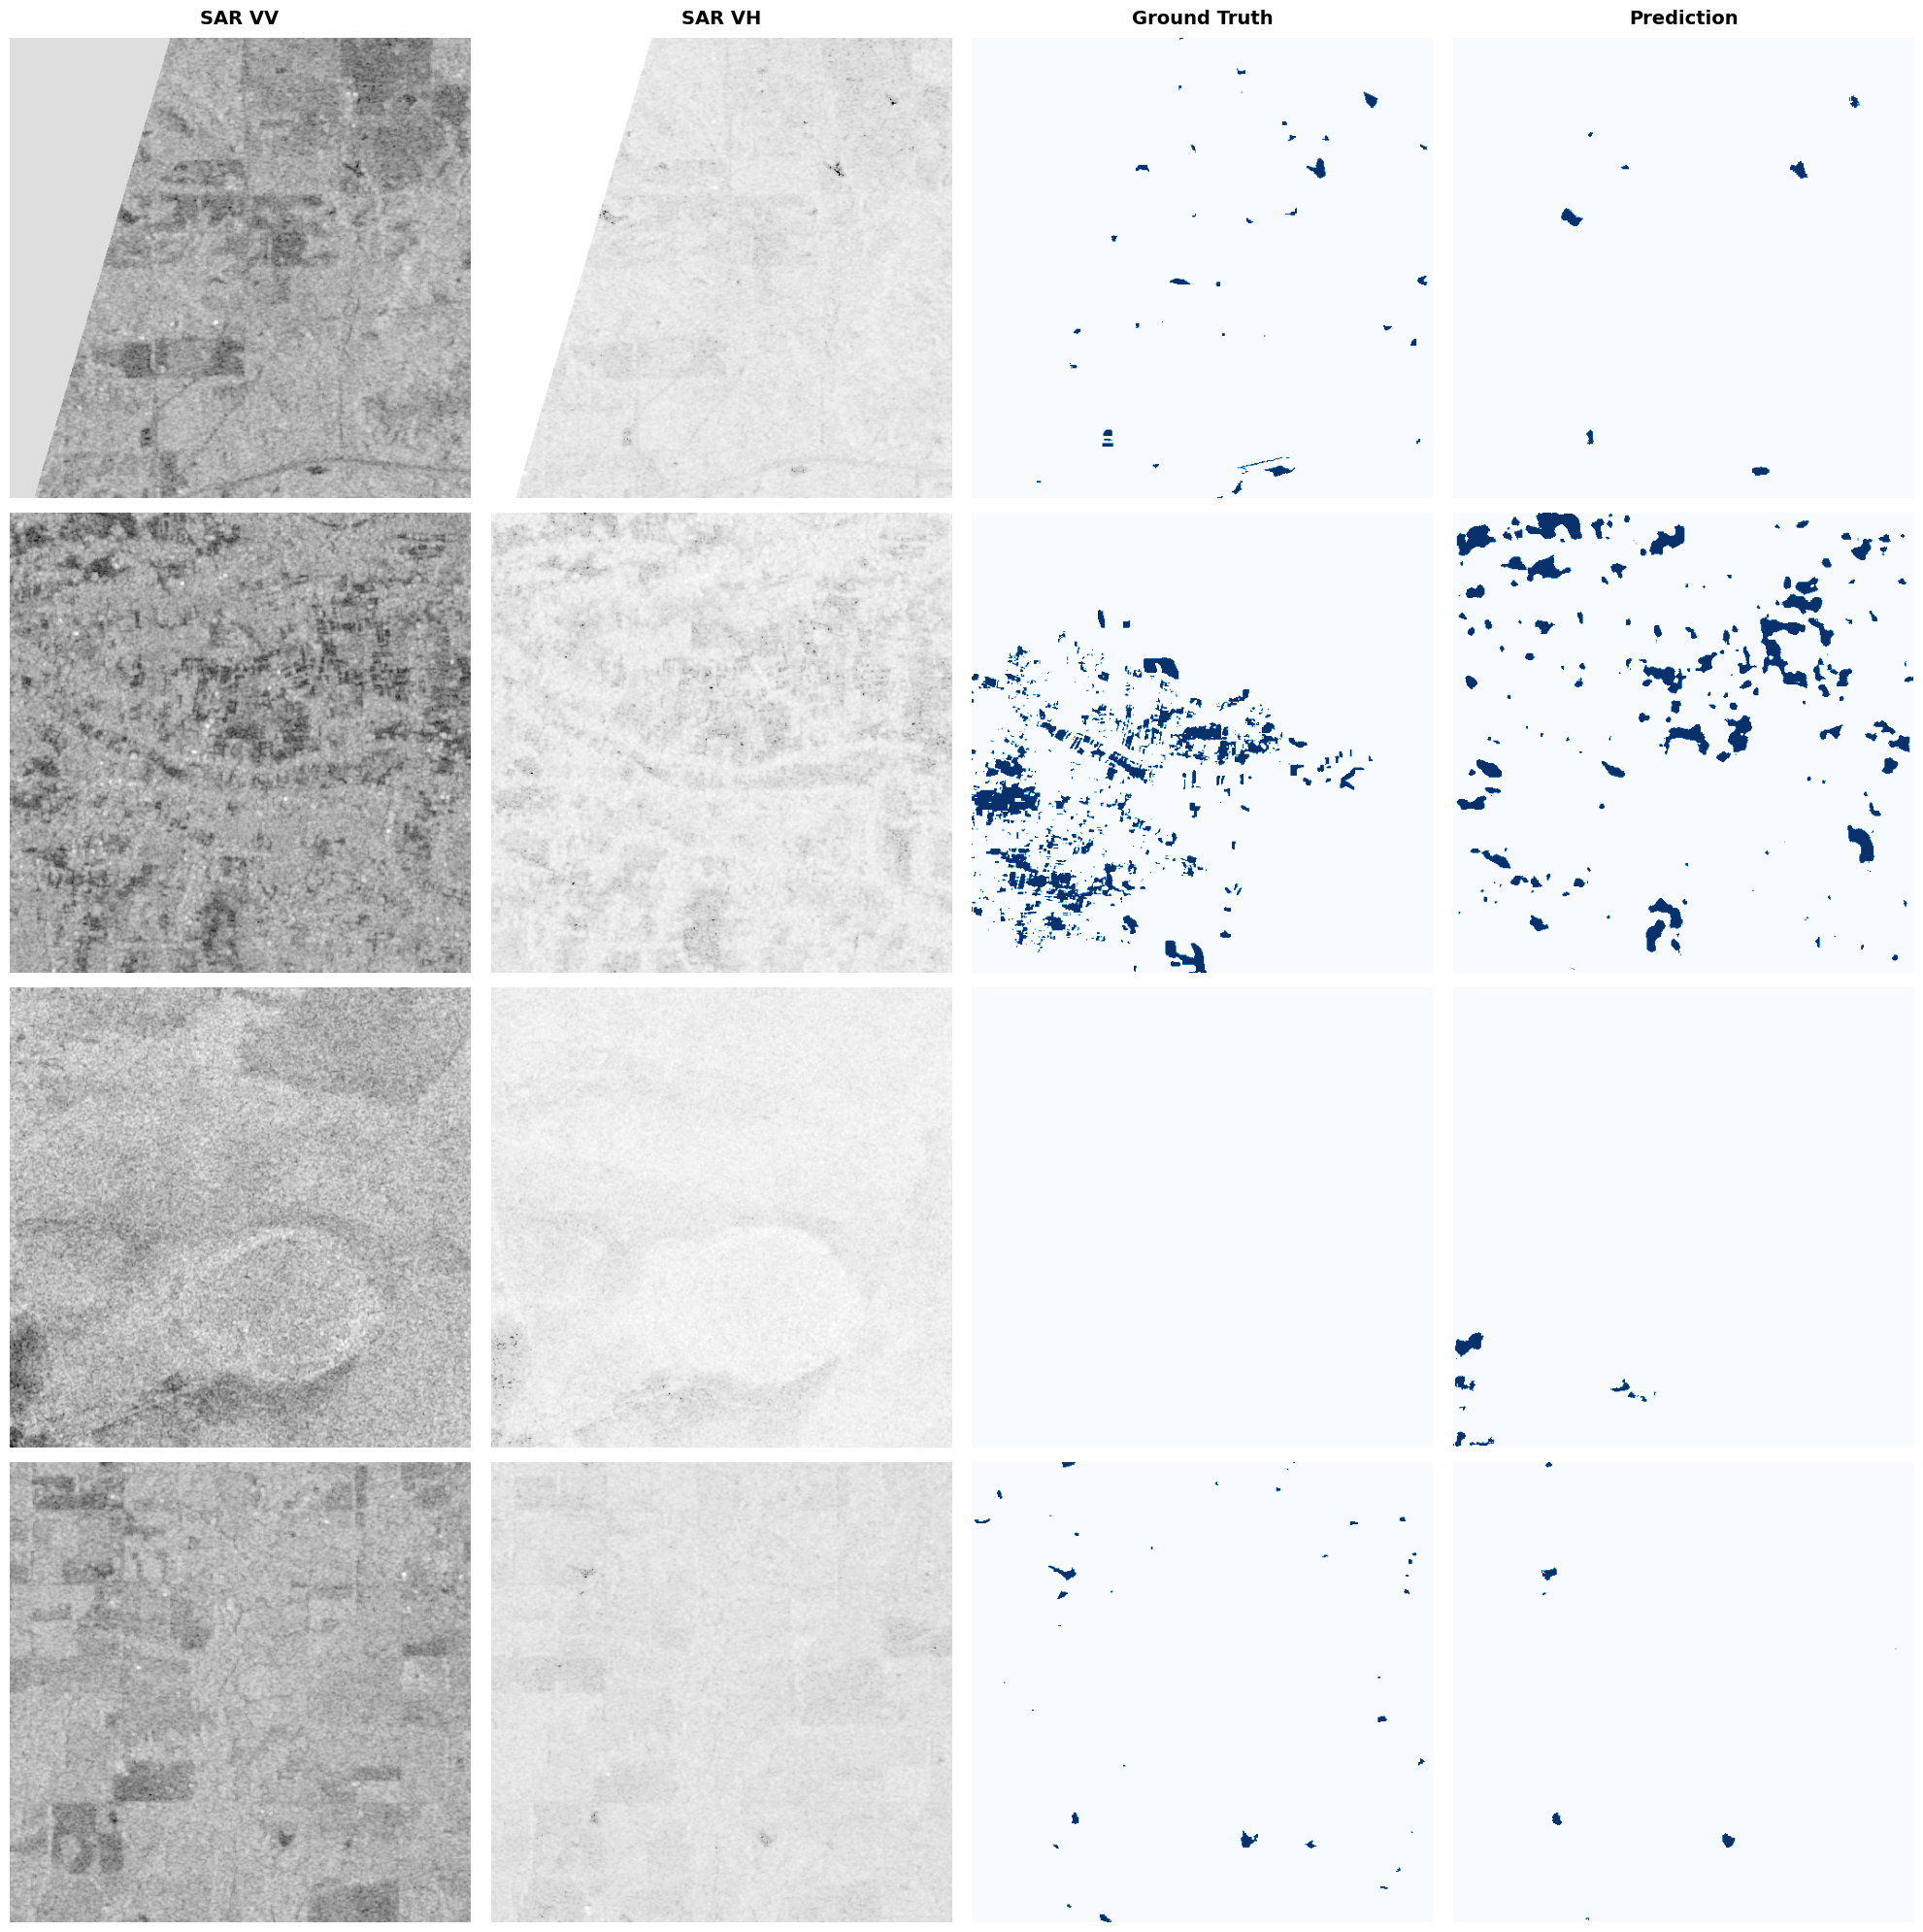

In [23]:
# ========================================
# VISUALIZE 4 EXAMPLES (High Resolution)
# ========================================

import matplotlib.pyplot as plt
import os

model.eval()
with torch.no_grad():
    x, y, valid = next(iter(test_dl))
    x, y = x.to(device), y.to(device)
    logits = model(x)
    preds = (torch.sigmoid(logits) > 0.5).float()

# Show first 4 samples in batch
num_samples = min(4, x.size(0))
fig, axes = plt.subplots(num_samples, 4, figsize=(20, 5*num_samples))

# Column titles (only at the top)
col_titles = ['SAR VV', 'SAR VH', 'Ground Truth', 'Prediction']
for col, title in enumerate(col_titles):
    axes[0, col].set_title(title, fontsize=14, fontweight='bold', pad=10)

# Plot images
for i in range(num_samples):
    axes[i, 0].imshow(x[i, 0].cpu(), cmap='gray')
    axes[i, 1].imshow(x[i, 1].cpu(), cmap='gray')
    axes[i, 2].imshow(y[i, 0].cpu(), cmap='Blues')
    axes[i, 3].imshow(preds[i, 0].cpu(), cmap='Blues')
    
    # Remove axis for all subplots
    for ax in axes[i]:
        ax.axis('off')

plt.tight_layout()

# Save high resolution
output_path = '/kaggle/working/segmentation_results_multiple.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()

## Phase 2: Using Learned Embeddings for Downstream Analysis

In this task, we will use the model’s learned embeddings to extract high-level SAR features and apply them to downstream tasks such as classification, similarity search, and clustering.

For the feature extraction pipeline, the fine-tuned encoder compresses 524,288 pixels into a 512-D embedding vector, creating a representation of flood-relevant patterns. 

Each feature captures patterns such as:
- Water darkness level
- Floodwater texture
- Linear structures (roads, levees)
- Smooth vs. rough backscatter
- Vegetation–water boundaries

The steps below show how we can extract and apply the following outputs:

- Reusable encoder weights
- Can be used as a universal SAR embedding generator for any Sentinel-1 image
- No retraining required for downstream tasks

To start with, we define a function to extract a reusable embedding from the model by running the data through the encoder and selecting its deepest feature map. It then applies global average pooling to compress each feature map into a single vector, giving one embedding per image that can be used for downstream analysis.

In [24]:
def extract_embedding(model, x_batch):
    """
    Extracts a reusable embedding from the deepest encoder feature map.
    Args:
        model: Trained segmentation model
        x_batch: (B, 2, H, W) - batch of SAR images

    Returns:
        pooled: (B, C) - fixed-size embedding per image
    """
    model.eval()
    with torch.no_grad():
        # SMP encoders return a list of feature maps → take deepest one
        feat_list = model.encoder(x_batch)      # list of tensors
        feats = feat_list[-1]                   # (B, C, H', W')

        # Global average pooling over spatial dims
        pooled = feats.mean(dim=(2, 3))         # (B, C)
    return pooled

We could use this embedding on its own as a compact representation of the SAR image. The `embedding` variable contains a 512-dimensional feature vector that represents the SAR image in a compressed, learned feature space.

In [25]:
# Extract embedding for a single new SAR image
single_image = torch.randn(1, 2, 512, 512).to(device)
embedding = extract_embedding(model, single_image)  # (1, 512)

print(embedding.shape)
print(type(embedding))

torch.Size([1, 512])
<class 'torch.Tensor'>


An example of this could be to determine whether a chip contains any flooded pixels. The below function generates a compact feature representation (embeddings) for each SAR image, and pairs those embeddings with simple flood/no-flood labels so they can be used for downstream analysis.

In [26]:
def compute_embeddings(dataloader, model, device="cuda"):
    """
    Returns:
      Z: (N, C) numpy array of embeddings
      Y: (N,) numpy array of chip-level labels (0/1)
    """
    all_z = []
    all_y = []

    model.eval()
    with torch.no_grad():
        for x, y, valid in dataloader:
            x = x.to(device)
            y = y.to(device)

            # 1) Compute embeddings
            z = extract_embedding(model, x)  # (B, C)
            all_z.append(z.cpu().numpy())

            # 2) Create simple chip-level label:
            #    1 if any flood pixel exists, else 0
            #    (you can refine this, e.g. >1% flood coverage)
            y_flat = y.view(y.size(0), -1)
            chip_label = (y_flat.max(dim=1).values > 0.5).float()
            all_y.append(chip_label.cpu().numpy())

    Z = np.concatenate(all_z, axis=0)
    Y = np.concatenate(all_y, axis=0)
    return Z, Y

In [27]:
Z_train, Y_train = compute_embeddings(train_dl, model, device=device)
Z_val,   Y_val   = compute_embeddings(val_dl,   model, device=device)
Z_test,  Y_test  = compute_embeddings(test_dl,  model, device=device)

print(Z_train.shape, Y_train.shape)

(105, 512) (105,)


In this demo we will test four downstream use cases, that have following potential policy applications:

1.Binary flood classification​

- Use embeddings or segmentation map to detect flood presence​.

​2. Similarity search​

- Find historical flood events that resemble a new disaster​.

​3. Clustering​

- Group floods by type (riverine, coastal, urban, shallow/deep patterns)​.

​4. Regional fine-tuning​

- Adapt to a new region with only 20–30 local images.

### Downstream Task 1: Flood Detection Classification

We now move to the first downstream task in our tutorial: chip-level classification.

We use `Z_train` which is an embedding matrix of shape (47. 512), with each row representing 512-dimensional feature vector produced by the encoder.

`Y_train` is the labels, each label = 0 (no flood) or 1 (flood exists somewhere in the chip)


Test Set Performance:
  Accuracy: 0.8696
  F1-Score: 0.9302

Classification Report:
              precision    recall  f1-score   support

    No Flood       0.00      0.00      0.00         1
       Flood       0.95      0.91      0.93        22

    accuracy                           0.87        23
   macro avg       0.48      0.45      0.47        23
weighted avg       0.91      0.87      0.89        23



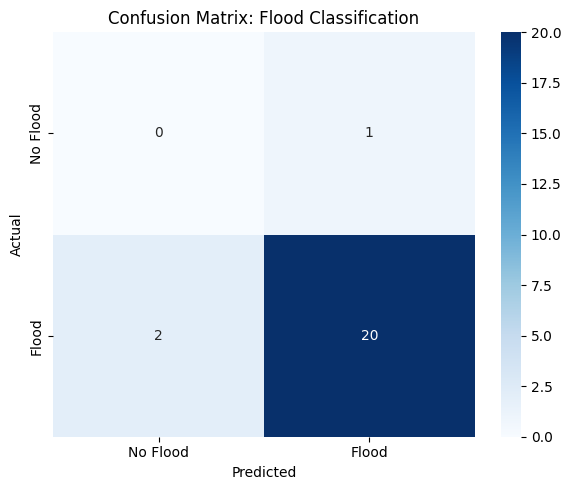

Saved: classification_confusion_matrix.png


In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns

# Train classifier on embeddings
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(Z_train, Y_train)

# Predict on test set
Y_pred_test = clf.predict(Z_test)

print(f"\nTest Set Performance:")
print(f"  Accuracy: {accuracy_score(Y_test, Y_pred_test):.4f}")

# Only compute F1 if both classes exist in predictions
if len(np.unique(Y_pred_test)) > 1:
    print(f"  F1-Score: {f1_score(Y_test, Y_pred_test):.4f}")
else:
    print(f"  F1-Score: N/A (model only predicts one class)")

print("\nClassification Report:")
print(classification_report(Y_test, Y_pred_test,
                          target_names=['No Flood', 'Flood'],
                          zero_division=0))

# Confusion matrix
cm = confusion_matrix(Y_test, Y_pred_test)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Flood', 'Flood'],
            yticklabels=['No Flood', 'Flood'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Flood Classification')
plt.tight_layout()
plt.savefig('classification_confusion_matrix.png', dpi=150)
plt.show()

print("Saved: classification_confusion_matrix.png")

The classifier performs well on the majority “Flood” class, achieving high precision (0.95) and a strong F1-score (0.93). However, it misses the single “No Flood” example in the test set, reflecting the heavy class imbalance from this small-scale example.

### Downstream Task 2: Image Similarity Search

We  conduct an image similarity search through using the similarity score metric of a **silhouette score** that measures how well-defined and separated the clusters are. This is different from the cosine similarity score as these are not normalised metrics. With high scores, there is a high chance of a flood. The silhouette score is useful when we want to see images similar to one another and shows how "one query" best matches training images. To do this: pick a query from the test set, retrieve its embedding, and compute similarity across all training images.


IMAGE SIMILARITY SEARCH RESULTS

🔍 Query Image: USA_347609
   Flood Status: 🌊 YES

📊 Top 5 Most Similar Training Images:
------------------------------------------------------------
  1. USA_58086
     Similarity: 1180.3770 | Flood: 🌊 YES
  2. India_207862
     Similarity: 1143.2050 | Flood: 🌊 YES
  3. USA_527077
     Similarity: 1117.0370 | Flood: 🌊 YES
  4. USA_308150
     Similarity: 1076.5930 | Flood: 🌊 YES
  5. USA_595451
     Similarity: 1047.4534 | Flood: 🌊 YES



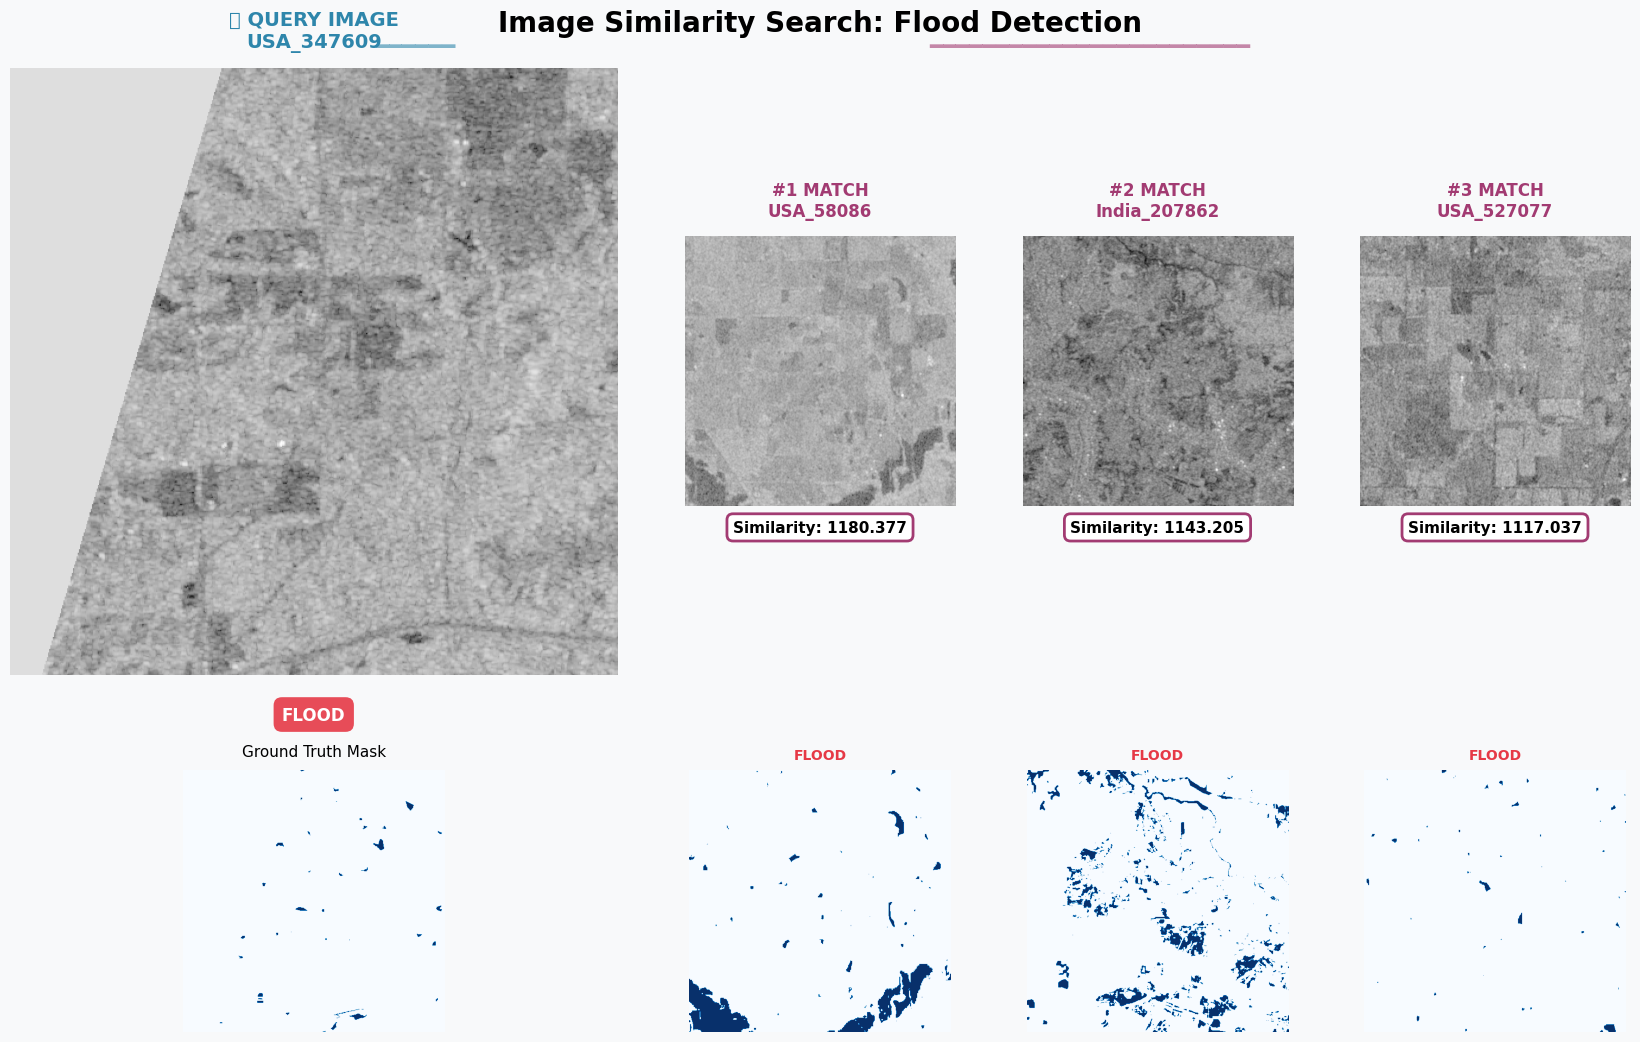

✅ Saved: similarity_search_results.png
   High-resolution visualization with enhanced styling


In [34]:
# Pick a query image from test set
query_idx = 0
query_chip_id = test_ids[query_idx]

# Get its embedding
model.eval()
with torch.no_grad():
    x_query, y_query, valid_query = test_ds[query_idx]
    x_query = x_query.unsqueeze(0).to(device)
    embedding_query = extract_embedding(model, x_query)

# Compute similarity to all training images
embedding_query_np = embedding_query.cpu().numpy()
similarities = np.dot(Z_train, embedding_query_np.T).flatten()
top_k = 5
top_indices = similarities.argsort()[-top_k:][::-1]

print(f"\n{'='*60}")
print(f"IMAGE SIMILARITY SEARCH RESULTS")
print(f"{'='*60}")
print(f"\n🔍 Query Image: {query_chip_id}")
print(f"   Flood Status: {'🌊 YES' if Y_test[query_idx] == 1 else '✓ NO'}")
print(f"\n📊 Top {top_k} Most Similar Training Images:")
print(f"{'-'*60}")
for rank, idx in enumerate(top_indices, 1):
    flood_emoji = '🌊' if Y_train[idx] == 1 else '✓'
    print(f"  {rank}. {train_ids[idx]}")
    print(f"     Similarity: {similarities[idx]:.4f} | Flood: {flood_emoji} {'YES' if Y_train[idx] == 1 else 'NO'}")
print(f"{'='*60}\n")

# Enhanced visualization
fig = plt.figure(figsize=(18, 11))
gs = fig.add_gridspec(3, 5, hspace=0.35, wspace=0.25,
                      left=0.05, right=0.95, top=0.93, bottom=0.05)

# Color scheme
query_color = '#2E86AB'
match_color = '#A23B72'
bg_color = '#F8F9FA'
fig.patch.set_facecolor(bg_color)

# Title
fig.suptitle('Image Similarity Search: Flood Detection',
             fontsize=20, fontweight='bold', y=0.98)

# === QUERY IMAGE SECTION ===
ax_query_img = fig.add_subplot(gs[0:2, 0:2])
ax_query_mask = fig.add_subplot(gs[2, 0:2])

x_q, y_q, _ = test_ds[query_idx]
ax_query_img.imshow(x_q[0].cpu(), cmap='gray')
ax_query_img.set_title(f'🔍 QUERY IMAGE\n{query_chip_id}',
                        fontsize=14, fontweight='bold',
                        color=query_color, pad=15)
ax_query_img.axis('off')

# Add flood status badge
flood_status = 'FLOOD' if Y_test[query_idx] == 1 else 'NO FLOOD'
flood_color = '#E63946' if Y_test[query_idx] == 1 else '#06A77D'
ax_query_img.text(0.5, -0.05, flood_status,
                  transform=ax_query_img.transAxes,
                  fontsize=12, fontweight='bold',
                  ha='center', va='top',
                  bbox=dict(boxstyle='round,pad=0.5',
                           facecolor=flood_color,
                           edgecolor='none', alpha=0.9),
                  color='white')

ax_query_mask.imshow(y_q[0].cpu(), cmap='Blues', vmin=0, vmax=1)
ax_query_mask.set_title('Ground Truth Mask', fontsize=11, pad=10)
ax_query_mask.axis('off')

# === TOP MATCHES SECTION ===
for i, idx in enumerate(top_indices[:3]):
    col = i + 2

    # Match image
    ax_match = fig.add_subplot(gs[0:2, col])
    x_similar, y_similar, _ = train_ds[idx]
    ax_match.imshow(x_similar[0].cpu(), cmap='gray')

    # Title with rank
    rank_badge = f'#{i+1}'
    ax_match.set_title(f'{rank_badge} MATCH\n{train_ids[idx]}',
                       fontsize=12, fontweight='bold',
                       color=match_color, pad=15)
    ax_match.axis('off')

    # Similarity score
    sim_score = similarities[idx]
    sim_text = f'{sim_score:.3f}'
    ax_match.text(0.5, -0.05, f'Similarity: {sim_text}',
                  transform=ax_match.transAxes,
                  fontsize=11, ha='center', va='top',
                  bbox=dict(boxstyle='round,pad=0.4',
                           facecolor='white',
                           edgecolor=match_color,
                           linewidth=2),
                  fontweight='bold')

    # Match mask
    ax_match_mask = fig.add_subplot(gs[2, col])
    ax_match_mask.imshow(y_similar[0].cpu(), cmap='Blues', vmin=0, vmax=1)

    # Flood status
    match_flood = 'FLOOD' if Y_train[idx] == 1 else 'NO FLOOD'
    match_flood_color = '#E63946' if Y_train[idx] == 1 else '#06A77D'
    ax_match_mask.set_title(match_flood,
                           fontsize=10, fontweight='bold',
                           color=match_flood_color, pad=8)
    ax_match_mask.axis('off')

# Add decorative elements
fig.text(0.275, 0.94, '━━━━━━', ha='center', fontsize=16,
         color=query_color, alpha=0.6)
fig.text(0.65, 0.94, '━━━━━━━━━━━━━━━━━━━━━━━━', ha='center',
         fontsize=16, color=match_color, alpha=0.6)

# Save with high quality
plt.savefig('similarity_search_results.png', dpi=200,
            facecolor=bg_color, bbox_inches='tight')
plt.show()

print("✅ Saved: similarity_search_results.png")
print("   High-resolution visualization with enhanced styling")

We can see that the USA query chip contains flooding, and the similarity search retrieves five training images that also show flooded areas. All top matches are flood cases with high similarity scores, indicating that the embedding space groups together SAR images with similar flood-related patterns. This suggests the model is successfully capturing features associated with flooding.

### Downstream Task 3: Clustering Analysis

Similar to our single query based similarity, we use the **silhouette score** metric for clustering analysis as well. As clustering is an unsupervised machine learning technique, the k means clustering approach will cluster in "n" clusters of 3, compute the silhouette score. It validates that the model learned meaningful features. From the output if the model is predicting floods in different clusters, then we know that the model has learnt some useful patterns.

Silhouette Score: 0.2615

Cluster distribution (test set):
  Cluster 0: 4 samples, 4 floods (100.0%)
  Cluster 1: 7 samples, 7 floods (100.0%)
  Cluster 2: 12 samples, 11 floods (91.7%)


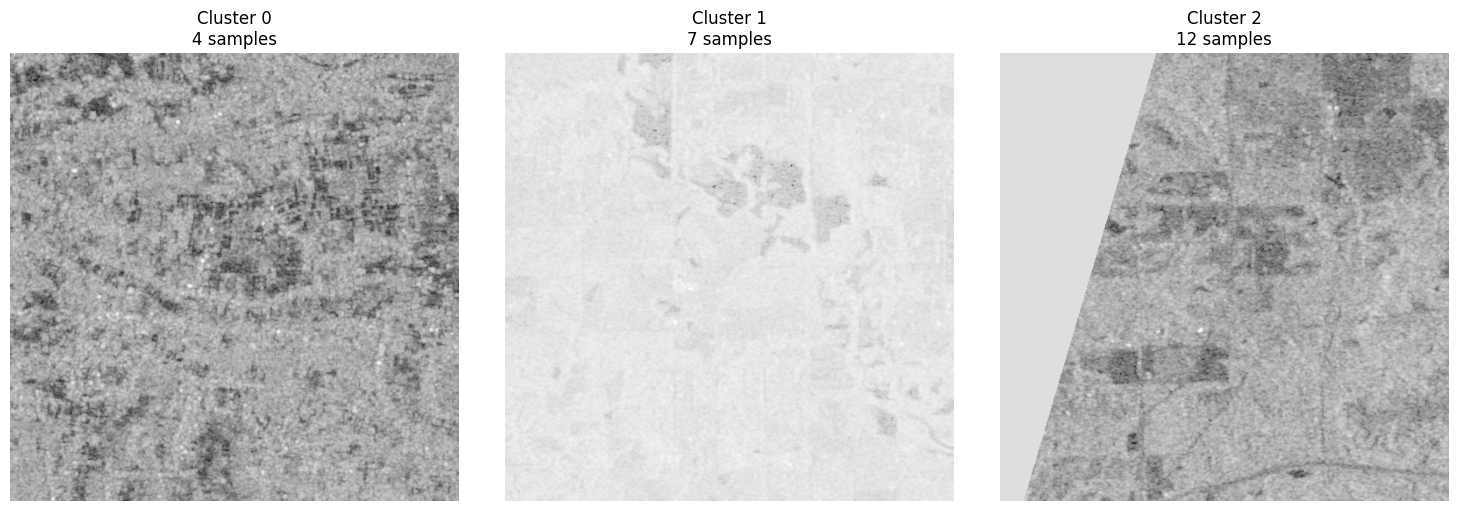

Saved: clustering_examples.png


In [37]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Cluster embeddings to discover flood patterns
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters_train = kmeans.fit_predict(Z_train)
clusters_test = kmeans.predict(Z_test)

sil_score = silhouette_score(Z_test, clusters_test)
print(f"Silhouette Score: {sil_score:.4f}")

print(f"\nCluster distribution (test set):")
for i in range(n_clusters):
    cluster_mask = clusters_test == i
    n_samples = cluster_mask.sum()
    n_floods = Y_test[cluster_mask].sum()
    print(f"  Cluster {i}: {n_samples} samples, {n_floods:.0f} floods ({100*n_floods/n_samples:.1f}%)")

# Visualize clusters
fig, axes = plt.subplots(1, n_clusters, figsize=(15, 5))

for cluster_id in range(n_clusters):
    # Find test samples in this cluster
    cluster_mask = clusters_test == cluster_id
    cluster_indices = np.where(cluster_mask)[0]

    if len(cluster_indices) > 0:
        # Show first sample from this cluster
        sample_idx = cluster_indices[0]
        x_sample, y_sample, _ = test_ds[sample_idx]

        axes[cluster_id].imshow(x_sample[0].cpu(), cmap='gray')
        axes[cluster_id].set_title(f'Cluster {cluster_id}\n{cluster_mask.sum()} samples')
        axes[cluster_id].axis('off')

plt.tight_layout()
plt.savefig('clustering_examples.png', dpi=150)
plt.show()

print("Saved: clustering_examples.png")

The silhouette score (0.26) indicates weak–moderate separation, meaning the clusters are somewhat distinct but not strongly so. Since all clusters still contain mostly flood cases, the clustering does not separate images by flood status; rather, it groups them by general SAR texture or appearance. This shows that the model has learned meaningful visual features, but those features do not strongly differentiate flooded vs. non-flooded scenes.

### Downstream Task 4: Cross-region Similarity



For this task, we compare two test SAR images by computing the cosine similarity between their learned embeddings, which measures how close the two images are in the model’s feature space. Cosine similarity ranges from –1 to 1, with values above 0.8 indicating strong similarity and values below 0.5 suggesting that the images are different. 

The visualization shows whether each image contains flooding, displays their SAR inputs and ground-truth masks, and uses color-coded indicators to reflect the similarity score. High similarity suggests shared structural or textural patterns, while low similarity indicates differences in appearance or flood characteristics. This helps illustrate how the model interprets and relates SAR scenes at a deeper feature level.




Comparing two SAR images:
  Image A: USA_347609 - Flood: Yes
  Image B: India_287642 - Flood: Yes
  Cosine Similarity: 0.4836
  → Different images (different regions/flood patterns)


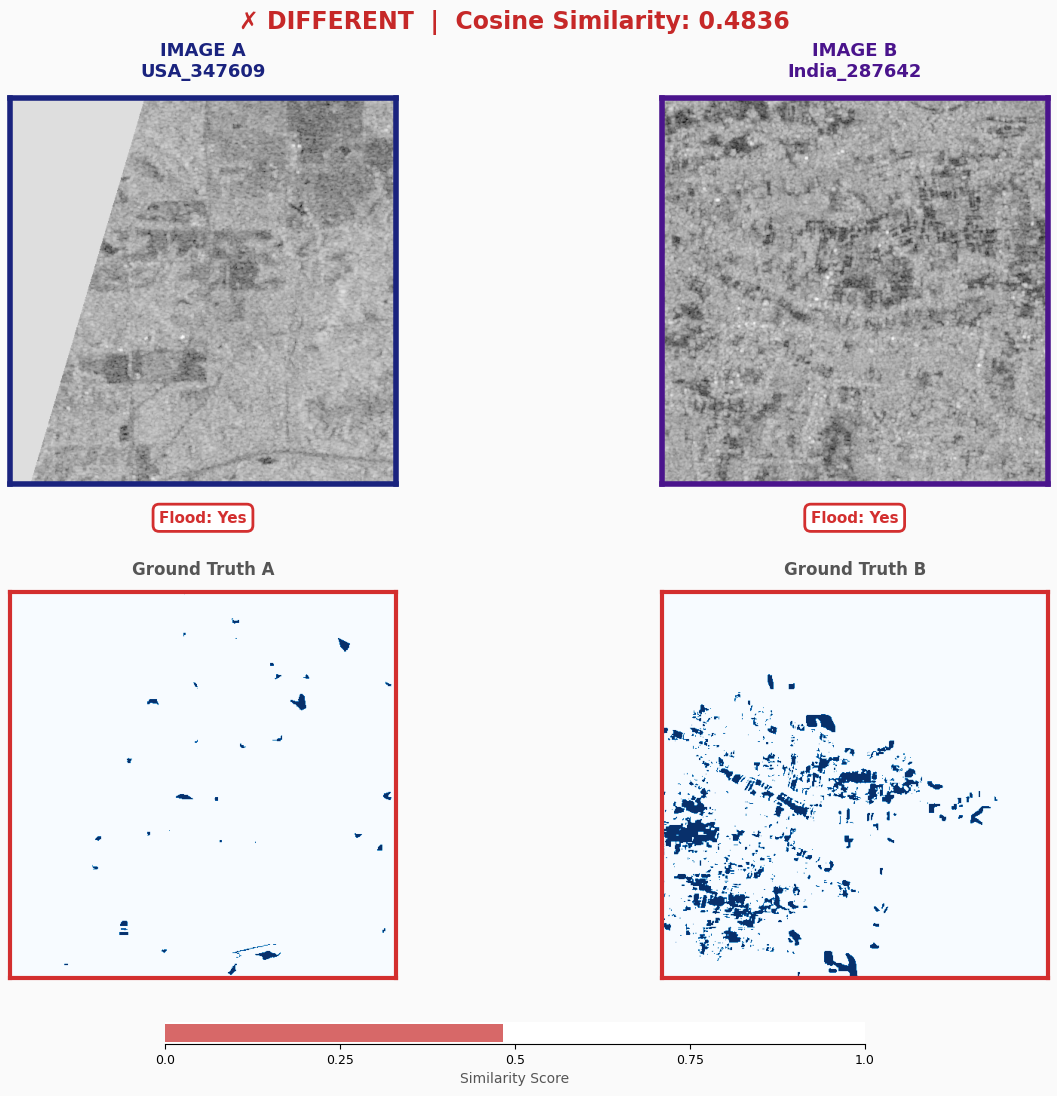

Saved: pairwise_comparison.png


In [38]:
# Compare two test images
idx_A, idx_B = 0, 1
model.eval()
with torch.no_grad():
    x_A, y_A, _ = test_ds[idx_A]
    x_B, y_B, _ = test_ds[idx_B]
    x_A_batch = x_A.unsqueeze(0).to(device)
    x_B_batch = x_B.unsqueeze(0).to(device)
    embedding_A = extract_embedding(model, x_A_batch)
    embedding_B = extract_embedding(model, x_B_batch)
    similarity = torch.cosine_similarity(embedding_A, embedding_B, dim=1).item()

print(f"\nComparing two SAR images:")
print(f"  Image A: {test_ids[idx_A]} - Flood: {'Yes' if Y_test[idx_A] == 1 else 'No'}")
print(f"  Image B: {test_ids[idx_B]} - Flood: {'Yes' if Y_test[idx_B] == 1 else 'No'}")
print(f"  Cosine Similarity: {similarity:.4f}")
if similarity > 0.8:
    print("  → Very similar images (likely same region/conditions)")
elif similarity > 0.5:
    print("  → Moderately similar images")
else:
    print("  → Different images (different regions/flood patterns)")

# Enhanced visualization with color-coded similarity
fig = plt.figure(figsize=(14, 11))
fig.patch.set_facecolor('#fafafa')
gs = fig.add_gridspec(2, 2, hspace=0.28, wspace=0.18,
                       left=0.08, right=0.94, top=0.88, bottom=0.08)

# Determine similarity level and color scheme
if similarity > 0.8:
    sim_text = "VERY SIMILAR"
    sim_color = '#2e7d32'  # Green
    sim_emoji = "✓"
elif similarity > 0.5:
    sim_text = "MODERATELY SIMILAR"
    sim_color = '#7b1fa2'  # Orange
    sim_emoji = "~"
else:
    sim_text = "DIFFERENT"
    sim_color = '#c62828'  # Red
    sim_emoji = "✗"

# Main title with similarity indicator
fig.suptitle(f'{sim_emoji} {sim_text}  |  Cosine Similarity: {similarity:.4f}',
             fontsize=17, fontweight='bold', color=sim_color, y=0.96)

# Flood status colors
flood_A = Y_test[idx_A] == 1
flood_B = Y_test[idx_B] == 1
color_A = '#d32f2f' if flood_A else '#388e3c'
color_B = '#d32f2f' if flood_B else '#388e3c'

axes = [[None, None], [None, None]]

# Image A - SAR (top-left)
axes[0][0] = fig.add_subplot(gs[0, 0])
axes[0][0].imshow(x_A[0].cpu(), cmap='gray')
axes[0][0].set_title(f'IMAGE A\n{test_ids[idx_A]}',
                     fontsize=13, fontweight='bold', pad=15, color='#1a237e')
# Colored border
for spine in axes[0][0].spines.values():
    spine.set_edgecolor('#1a237e')
    spine.set_linewidth(4)
axes[0][0].set_xticks([])
axes[0][0].set_yticks([])
# Flood label
axes[0][0].text(0.5, -0.1, f'Flood: {"Yes" if flood_A else "No"}',
                transform=axes[0][0].transAxes, ha='center',
                fontsize=11, fontweight='bold', color=color_A,
                bbox=dict(boxstyle='round,pad=0.4', facecolor='white',
                         edgecolor=color_A, linewidth=2))

# Image B - SAR (top-right)
axes[0][1] = fig.add_subplot(gs[0, 1])
axes[0][1].imshow(x_B[0].cpu(), cmap='gray')
axes[0][1].set_title(f'IMAGE B\n{test_ids[idx_B]}',
                     fontsize=13, fontweight='bold', pad=15, color='#4a148c')
# Colored border
for spine in axes[0][1].spines.values():
    spine.set_edgecolor('#4a148c')
    spine.set_linewidth(4)
axes[0][1].set_xticks([])
axes[0][1].set_yticks([])
# Flood label
axes[0][1].text(0.5, -0.1, f'Flood: {"Yes" if flood_B else "No"}',
                transform=axes[0][1].transAxes, ha='center',
                fontsize=11, fontweight='bold', color=color_B,
                bbox=dict(boxstyle='round,pad=0.4', facecolor='white',
                         edgecolor=color_B, linewidth=2))

# Ground Truth A (bottom-left)
axes[1][0] = fig.add_subplot(gs[1, 0])
axes[1][0].imshow(y_A[0].cpu(), cmap='Blues', vmin=0, vmax=1)
axes[1][0].set_title('Ground Truth A', fontsize=12, pad=12,
                     color='#555', fontweight='bold')
for spine in axes[1][0].spines.values():
    spine.set_edgecolor(color_A)
    spine.set_linewidth(3)
axes[1][0].set_xticks([])
axes[1][0].set_yticks([])

# Ground Truth B (bottom-right)
axes[1][1] = fig.add_subplot(gs[1, 1])
axes[1][1].imshow(y_B[0].cpu(), cmap='Blues', vmin=0, vmax=1)
axes[1][1].set_title('Ground Truth B', fontsize=12, pad=12,
                     color='#555', fontweight='bold')
for spine in axes[1][1].spines.values():
    spine.set_edgecolor(color_B)
    spine.set_linewidth(3)
axes[1][1].set_xticks([])
axes[1][1].set_yticks([])

# Add similarity indicator bar
bar_ax = fig.add_axes([0.25, 0.02, 0.5, 0.02])
bar_ax.barh(0, similarity, color=sim_color, height=0.8, alpha=0.7)
bar_ax.set_xlim(0, 1)
bar_ax.set_ylim(-0.5, 0.5)
bar_ax.set_xticks([0, 0.25, 0.5, 0.75, 1.0])
bar_ax.set_xticklabels(['0.0', '0.25', '0.5', '0.75', '1.0'], fontsize=9)
bar_ax.set_yticks([])
bar_ax.spines['top'].set_visible(False)
bar_ax.spines['right'].set_visible(False)
bar_ax.spines['left'].set_visible(False)
bar_ax.set_xlabel('Similarity Score', fontsize=10, color='#555')

plt.savefig('pairwise_comparison.png', dpi=150, bbox_inches='tight',
            facecolor='#fafafa')
plt.show()
print("Saved: pairwise_comparison.png")

Although both SAR chips contain flooding, their cosine similarity is relatively low (0.48), indicating that the model classifies them as different in the learned feature space. The ground-truth masks also show very different flood extents and spatial patterns, and the underlying SAR textures differ noticeably between the U.S. and India scenes. This suggests that the embedding captures regional and structural differences in addition to flood presence, leading the model to consider these images dissimilar despite both containing flood signals.

The key takeaway from Phase 2 of this demo shows that the fine-tuned encoder serves as a reusable Sentinel-1 representation model: it enables downstream tasks without retraining, allows fast deployment, supports efficient fine-tuning, and versatile analysis workflows.

## SUMMARY


This tutorial demonstrated that transfer learning enables effective flood detection with limited data. Our U-Net model achieved 94.8% pixel accuracy and 0.63 IoU on multi-country test data using only 150 training images. The two-stage approach—first training the decoder with a frozen encoder, then fine-tuning the full network—successfully adapted ImageNet features to SAR flood mapping in just 13 epochs. Beyond segmentation, the learned embeddings proved highly versatile for downstream tasks, achieving 87% flood classification accuracy, successfully retrieving similar historical flood events, and identifying regional patterns through clustering—all without additional training. This demonstrates that a single trained model can support multiple analytical workflows for disaster management.

The policy implications are significant. Government agencies can use this approach to rapidly map flood extent during emergencies, identify vulnerable regions with similar characteristics, and analyze historical precedents for preparedness planning. For example, a local emergency management agency could fine-tune our model with just 20-30 regional images to adapt it for their specific geography, enabling faster response times and better-informed decision-making during flood events. While our model has limitations—including class imbalance and moderate clustering separation but it provides a practical foundation for operational flood monitoring and data-driven climate adaptation in resource-constrained settings.


### References and further reading:

Bonafilia, D., Tellman, B., Anderson, T., & Issenberg, E. (2020). Sen1Floods11: A georeferenced dataset to train and test deep learning flood algorithms for Sentinel-1. In Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition Workshops (CVPRW) (pp. 835–845). https://doi.org/10.1109/CVPRW50498.2020.00113

Pan, S. J., & Yang, Q. (2010). A survey on transfer learning. IEEE Transactions on Knowledge and Data Engineering, 22(10), 1345–1359. https://doi.org/10.1109/TKDE.2009.191

United Nations Office for Disaster Risk Reduction. (2025). GAR 2025 hazards: Floods. https://www.undrr.org/gar/gar2025/hazard-exploration/floods

#### GenAI Statement:

Our group used GenAI tools such as GPT-5 to assist us in generating, reviewing and testing the code for this tutorial. In addition, GenAI tools were used to assist in theoretical understanding of the concepts covered. The final structure, design, explanation, and content of this tutorial is the work of the group members. 